In [5]:
import numpy as np
import pylab as plt
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import umap
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
import h5py
import pickle

plt.rcParams['font.size'] = 16


In [2]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())


['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

In [6]:
# model_name = 'convnext'
# model_sizes = ['tiny', 'small', 'base', 'large']
# model_name = 'vit'
# model_sizes = ['base_16', 'large_16', 'huge_14']
# model_name = 'dino'
# model_sizes = ['s_14', 'b_14', 'l_14', 'g_14']
model_name = 'astroPT'
model_sizes = ['015M', '095M', '850M']
n = 5000
telescope = 'hsc'
upsampled = True
dir_out = '/pscratch/sd/a/ashodkh/platonic_universe/embeddings/'

embeddings = {}

for model_size in model_sizes:
    if upsampled:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_{model_name}_{model_size}_upsampled_images.npy')
    else:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}.npy')

if model_name == 'astroPT':
    with open(dir_out + f'features_{telescope}_{n}_{model_name}_{model_size}_upsampled_images.pkl', 'rb') as pickle_f:
        features = pickle.load(pickle_f)
        

In [7]:
umap_embeddings = {}
for model_size in model_sizes:
    reducer = umap.UMAP(n_components=2)
    umap_embeddings[model_size] = reducer.fit_transform(embeddings[model_size])


In [8]:
mags = []
if telescope == 'hsc':
    bands = ['g', 'r', 'z']
    if model_name == 'astroPT':
        mags = [features[f'mag_model_hsc-{band}'] for band in bands]
    else:
        mags = [f[f'mag_model_hsc-{band}'][:n] for band in bands]
    

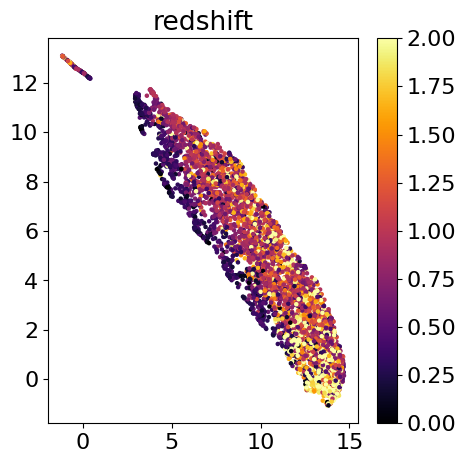

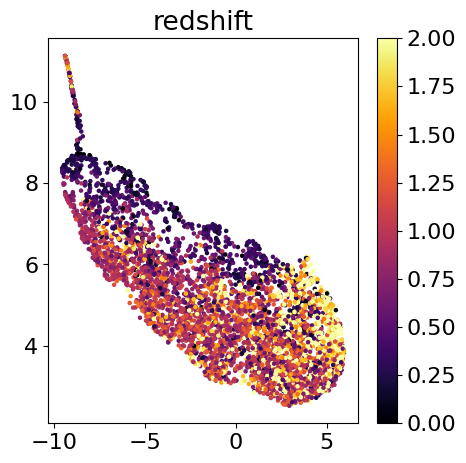

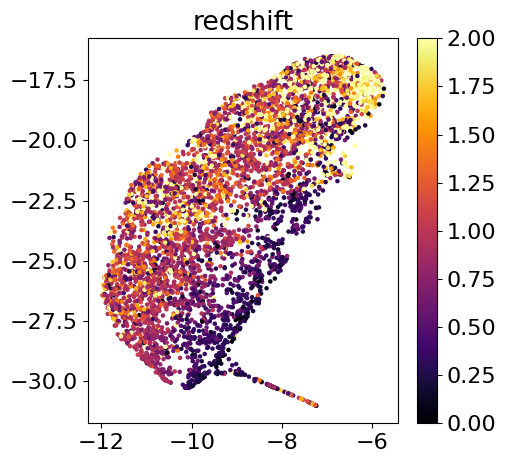

In [9]:
pp = PdfPages(dir_out + f'umaps_{telescope}_{n}_{model_name}_upsampled_images.pdf')
for model_size in model_sizes:
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    
    for j, band in enumerate(bands):
        sd = ax[j].scatter(umap_embeddings[model_size][:,0], umap_embeddings[model_size][:,1], c=mags[j], s=5, vmin=18, vmax=26, cmap='inferno');
        ax[j].set_title(band)
        fig.colorbar(sd, ax=ax[j])

    fig.suptitle(model_name + ' ' + model_size)
    pp.savefig(fig)
    plt.close(fig)

for model_size in model_sizes:
    fig, ax = plt.subplots(figsize=(5,5))

    if model_name == 'astroPT':
        sd = ax.scatter(umap_embeddings[model_size][:,0], umap_embeddings[model_size][:,1], c=features['lephare_photozs'], s=5, vmin=0, vmax=2, cmap='inferno');
    else:
        sd = ax.scatter(umap_embeddings[model_size][:,0], umap_embeddings[model_size][:,1], c=f['lephare_photozs'][:n], s=5, vmin=0, vmax=2, cmap='inferno');
    ax.set_title('redshift')
    fig.colorbar(sd, ax=ax)
    pp.savefig(fig)

pp.close()
    

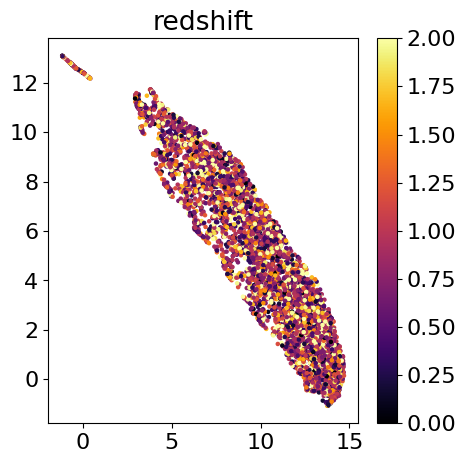

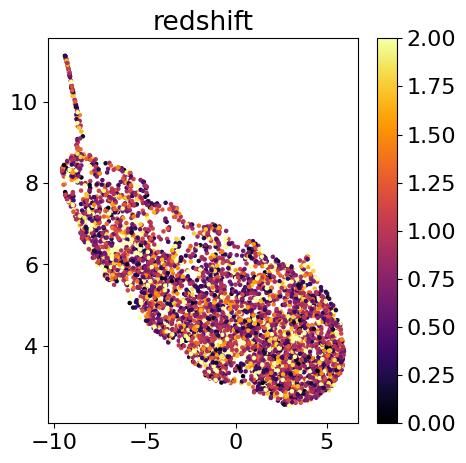

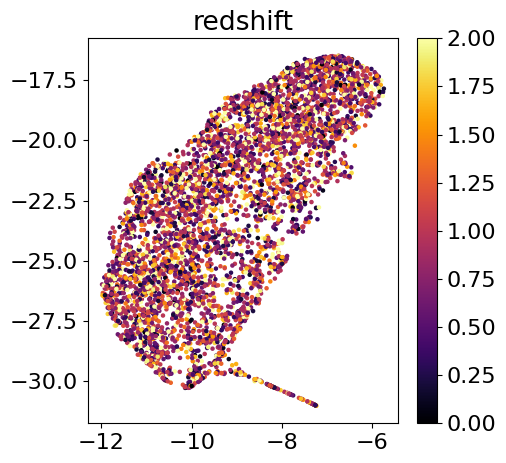

In [10]:
for model_size in model_sizes:
    fig, ax = plt.subplots(figsize=(5,5))

    sd = ax.scatter(umap_embeddings[model_size][:,0], umap_embeddings[model_size][:,1], c=f['lephare_photozs'][:n], s=5, vmin=0, vmax=2, cmap='inferno');
    ax.set_title('redshift')
    fig.colorbar(sd, ax=ax)
